In [157]:
import copy
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import sklearn

from sklearn.metrics import accuracy_score as acc
from sklearn.neighbors import KNeighborsClassifier as knnc
from tqdm import tqdm

import torch
import torchvision
import torchvision.transforms as transforms

In [160]:
pwd

'/Users/lucasmueller/Repositories/DeepVisionLecture/sheet02'

# Preliminaries

In [105]:
# Download the data

# pytorch version
trainset = torchvision.datasets.CIFAR10(root='./data_pytorch', train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root='./data_pytorch', train=False, download=True, transform=transforms.ToTensor())

# slight abuse of the dataloaders to get the desired size
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10000, shuffle=False, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=5000, shuffle=False, num_workers=0)

class Dataset:
    # small class to convert from pytorch dimension order to sklearn
    def __init__(self, loader):
        # input is a pytorch loader
        self.loader = loader
        self.x, self.y = iter(self.loader).next()
        self.pred = None
        
        # change dimension order (from NCHW to NHWC)
        self.x = self.x.permute(0, 2, 3, 1)
    
    def skl(self):
        # get output for sklearn algorithm (flatten)
        
        x = self.x.contiguous().view(self.x.size(0), -1).numpy()
        y = self.y.numpy()
        
        return x, y
    
trainset = Dataset(trainloader)
testset = Dataset(testloader)

print(trainset.x.shape)
print(trainset.y.shape)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([10000, 32, 32, 3])
torch.Size([10000])


In [106]:
class FeatureExtraction:
    def __init__(self):
        # pytorch dataset goes from 0 to 1, not 0 to 255
        self.edges = np.linspace(0, 1, 10+1)
    

    def get_features(self, img):
        red, _ = np.histogram(img[:, :, 0].flatten(), self.edges)
        green, _ = np.histogram(img[:, :, 1].flatten(), self.edges)
        blue, _ = np.histogram(img[:, :, 2].flatten(), self.edges)
        
        return np.concatenate([red, blue, green]).reshape([1, -1])
    
    def foward(self, dataset):
        dlen = dataset.x.shape[0]
        features = np.empty((dlen, 30))
        
        for i in range(dlen):
            features[i, :] = self.get_features(dataset.x[i, :, :, :])
            
        dataset.features = features
        
        return dataset

In [107]:
trainset_feat = FeatureExtraction().foward(trainset)
testset_feat = FeatureExtraction().foward(testset)

# Task 1: Linear Classifier with Least Squares

In [130]:
from scipy.optimize import least_squares as lsq
from scipy.optimize import curve_fit as cf

In [149]:
class LSQclassifier:
    def __init__(self):
        self.lin = self.linear_function
        self.w = None
        
    @staticmethod
    def linear_function(param, x, y=None):
        # expand weights
        param = np.expand_dims(param, 1)
        
        # construct the design matrix which is N x (D + 1), where N: num samples, D dimensionality, 
        # and 0th dimension of all samples is set to 0, so the 0th weight is the bias.
        X = np.ones((x.shape[0], x.shape[1] + 1))
        X[:, 1:] = x
        
        # set y to zero if not provided. this is to use this function in lsq directly.
        if y is None:
            y = np.zeros(x.shape[0])
        
        return np.matmul(X, param).squeeze() - y
    
    def fit(self,x,y):
        w_ini = np.random.rand(31)
        w_fin = lsq(self.linear_function, w_ini, args=(x, y))
        self.w = w_fin.x
    
    def predict(self, x):
        pred = np.sign(self.linear_function(self.w, x, None))
        return pred

In [162]:
lsqc = LSQclassifier()

In [163]:
from material.exercise2 import get_two_classes, accuracy_score
x, y, x_test, y_test = get_two_classes(trainset_feat.features, trainset_feat.y.numpy(), 
                                       testset_feat.features, testset.y.numpy())

In [164]:
lsqc.fit(x, y)
y_train_out = lsqc.predict(x)
y_test_out = lsqc.predict(x_test)

In [165]:
train_acc = accuracy_score(y,y_train_out)
test_acc  = accuracy_score(y_test,y_test_out)
print('Linear Classifier: Train %.2f, Test %.2f'%(train_acc,test_acc))

Linear Classifier: Train 0.86, Test 0.85


<BarContainer object of 31 artists>

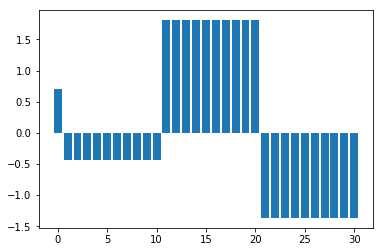

In [168]:
plt.bar(np.arange(lsqc.w.shape[0]), lsqc.w.squeeze())

# Task 2: Linear SVM

In [34]:
from sklearn.svm import LinearSVC

In [91]:
clf = LinearSVC(random_state=0, tol=1e-5, max_iter=10000)
clf.fit(x, y)
y_train_out = clf.predict(x)
y_test_out = clf.predict(x_test)

/Users/lucasmueller/anaconda/envs/deepvisionlecture/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [92]:
train_acc = accuracy_score(y,y_train_out)
test_acc  = accuracy_score(y_test,y_test_out)
print('Linear SVM classifier: Train %.2f, Test %.2f'%(train_acc,test_acc))

Linear SVM classifier: Train 0.71, Test 0.72


In [50]:
weight = clf.coef_

<BarContainer object of 30 artists>

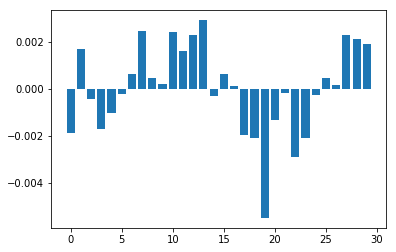

In [57]:
plt.bar(np.arange(weight.shape[1]), weight.squeeze())

# Task 3: Non-Linear SVM

In [76]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer

In [66]:
param = {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['poly', 'rbf', 'sigmoid']}

In [67]:
svc = SVC()

In [78]:
acc_acut = make_scorer(accuracy_score)
clf = GridSearchCV(svc, param, scoring=acc_acut, cv=5, n_jobs=-1)
clf.fit(x, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['poly', 'rbf', 'sigmoid']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(accuracy_score), verbose=0)

In [81]:
print(clf.best_params_)

{'C': 1, 'gamma': 0.001, 'kernel': 'poly'}


In [83]:
svc_tuned = SVC(C=1, gamma=0.001, kernel='poly')
svc_tuned.fit(x, y)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [84]:
y_train_out = clf.predict(x)
y_test_out = clf.predict(x_test)

In [86]:
train_acc = accuracy_score(y,y_train_out)
test_acc  = accuracy_score(y_test,y_test_out)
print('Non-Linear SVM classifier: Train %.2f, Test %.2f'%(train_acc,test_acc))

Non-Linear SVM classifier: Train 1.00, Test 0.81


What we see is that our SVM has now quite some overfit on the training data. This is not really surprising as high dimensionality increases the chance of overfitting.
The authors of the original paper state that 

E[P(error)] <= E[num support vec] / (num_train_vec)

# Task 5: Multi-Class Linear SVM

In [93]:
from material.exercise2 import get_multiple_classes
x, y, x_test, y_test = get_multiple_classes(trainset_feat.features, trainset_feat.y.numpy(), 
                                       testset_feat.features, testset.y.numpy())

In [95]:
clf = LinearSVC(random_state=0, tol=1e-5, max_iter=1000)
clf.fit(trainset_feat.features, trainset_feat.y)
y_train_out = clf.predict(x)
y_test_out = clf.predict(x_test)

/Users/lucasmueller/anaconda/envs/deepvisionlecture/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [96]:
train_acc = accuracy_score(y,y_train_out)
test_acc  = accuracy_score(y_test,y_test_out)
print('(Multi-class) Linear SVM: Train %.2f, Test %.2f'%(train_acc,test_acc))

(Multi-class) Linear SVM: Train 0.25, Test 0.25


Better than uninformed guessing

# Task 6: Classification by Logistic Regression with Pytorch

1. nn. Linear is a fully connected layer in a NN

2. criterion is a a cost functions (most commonly a loss) which is minimised by the optimizer

3.  In loss.backward() the backpropagation algorithm is applied and the gradients with respect to each trainable parameter is being computed

4. Based on the weight of the gradient of the gradient an optimiser updates the trainable parameters. The updated is determined by the gradient and some other hyper-parameters such as learning rate, etc.

In [100]:
import torch
import torch.nn as nn
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.linear(x)
        return out

# Create binary task
x,y,x_test,y_test = get_multiple_classes(trainset_feat.features, trainset_feat.y.numpy(), 
                                       testset_feat.features, testset.y.numpy())

model = LogisticRegression(x.shape[1], len(np.unique(y)))

# Loss and Optimizer
# Softmax is internally computed.
# Set parameters to be updated.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

X = torch.from_numpy(x.astype('float32'))
Y = torch.from_numpy(y)

loss_history = []

num_epochs = 2000
for epoch in range(num_epochs):
    # Forward + Backward + Optimize
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, Y)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if epoch%1000==0 and epoch>0:
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)
    if epoch%100==0:
        print ('Epoch: [%d/%d], Loss: %.4f'%(
            epoch+1, num_epochs,loss.item()))

pred = model(torch.from_numpy(x.astype('float32'))).argmax(1)
train_acc  = accuracy_score(y,pred.detach().numpy())
pred = model(torch.from_numpy(x_test.astype('float32'))).argmax(1)
test_acc  = accuracy_score(y_test,pred.detach().numpy())
print('Linear classifier by least square: Train %.2f, Test %.2f'%(train_acc,test_acc))

Epoch: [1/2000], Loss: 87.0194
Epoch: [101/2000], Loss: 14.5834
Epoch: [201/2000], Loss: 8.1591
Epoch: [301/2000], Loss: 5.7632
Epoch: [401/2000], Loss: 4.5518
Epoch: [501/2000], Loss: 3.4706
Epoch: [601/2000], Loss: 4.2479
Epoch: [701/2000], Loss: 3.7079
Epoch: [801/2000], Loss: 5.7202
Epoch: [901/2000], Loss: 3.2834
Epoch: [1001/2000], Loss: 5.9474
Epoch: [1101/2000], Loss: 1.3158
Epoch: [1201/2000], Loss: 1.2535
Epoch: [1301/2000], Loss: 1.2135
Epoch: [1401/2000], Loss: 1.1864
Epoch: [1501/2000], Loss: 1.1670
Epoch: [1601/2000], Loss: 1.1521
Epoch: [1701/2000], Loss: 1.1403
Epoch: [1801/2000], Loss: 1.1305
Epoch: [1901/2000], Loss: 1.1223
Linear classifier by least square: Train 0.57, Test 0.56


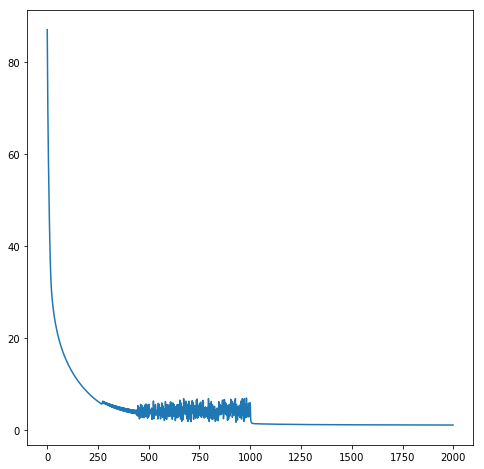

In [102]:
plt.figure(figsize=(8, 8))
plt.plot(loss_history)